In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "high_z"
key = "z"
quantile = "1"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

8it [00:00, 79.33it/s]

20it [00:00, 87.92it/s]

31it [00:00, 91.95it/s]

43it [00:00, 98.46it/s]

55it [00:00, 103.29it/s]

67it [00:00, 104.67it/s]

79it [00:00, 107.99it/s]

92it [00:00, 111.41it/s]

105it [00:00, 113.74it/s]

117it [00:01, 113.51it/s]

129it [00:01, 110.38it/s]

140it [00:01, 107.98it/s]

152it [00:01, 111.22it/s]

165it [00:01, 114.14it/s]

178it [00:01, 116.22it/s]

191it [00:01, 117.48it/s]

204it [00:01, 118.66it/s]

217it [00:01, 119.76it/s]

229it [00:02, 110.46it/s]

241it [00:02, 109.62it/s]

253it [00:02, 111.40it/s]

266it [00:02, 113.97it/s]

278it [00:02, 113.46it/s]

290it [00:02, 113.83it/s]

303it [00:02, 116.44it/s]

316it [00:02, 118.59it/s]

329it [00:02, 120.20it/s]

342it [00:02, 120.95it/s]

355it [00:03, 119.39it/s]

367it [00:03, 119.23it/s]

379it [00:03, 118.43it/s]

391it [00:03, 118.16it/s]

404it [00:03, 119.04it/s]

417it [00:03, 119.43it/s]

429it [00:03, 117.70it/s]

441it [00:03, 117.30it/s]

453it [00:03, 115.38it/s]

465it [00:04, 114.11it/s]

478it [00:04, 116.43it/s]

491it [00:04, 118.24it/s]

503it [00:04, 113.25it/s]

515it [00:04, 114.92it/s]

527it [00:04, 114.93it/s]

539it [00:04, 114.99it/s]

551it [00:04, 115.04it/s]

563it [00:04, 115.48it/s]

575it [00:04, 116.69it/s]

587it [00:05, 104.60it/s]

599it [00:05, 107.86it/s]

612it [00:05, 111.69it/s]

624it [00:05, 111.91it/s]

637it [00:05, 114.84it/s]

649it [00:05, 116.18it/s]

661it [00:05, 115.07it/s]

673it [00:05, 102.01it/s]

684it [00:06, 98.31it/s] 

695it [00:06, 100.20it/s]

707it [00:06, 103.85it/s]

718it [00:06, 93.08it/s] 

729it [00:06, 97.46it/s]

740it [00:06, 99.25it/s]

752it [00:06, 104.34it/s]

764it [00:06, 108.58it/s]

777it [00:06, 112.51it/s]

789it [00:07, 114.61it/s]

802it [00:07, 116.51it/s]

815it [00:07, 118.48it/s]

828it [00:07, 119.42it/s]

841it [00:07, 119.87it/s]

854it [00:07, 115.32it/s]

866it [00:07, 95.54it/s] 

877it [00:07, 99.12it/s]

890it [00:07, 104.98it/s]

902it [00:08, 108.53it/s]

914it [00:08, 111.37it/s]

927it [00:08, 113.92it/s]

939it [00:08, 115.53it/s]

951it [00:08, 116.63it/s]

964it [00:08, 117.88it/s]

976it [00:08, 117.85it/s]

989it [00:08, 118.73it/s]

1002it [00:08, 119.36it/s]

1014it [00:09, 110.63it/s]

1026it [00:09, 109.40it/s]

1038it [00:09, 109.10it/s]

1049it [00:09, 109.12it/s]

1061it [00:09, 112.03it/s]

1074it [00:09, 114.24it/s]

1086it [00:09, 115.10it/s]

1098it [00:09, 116.48it/s]

1111it [00:09, 117.73it/s]

1123it [00:09, 113.38it/s]

1135it [00:10, 114.10it/s]

1147it [00:10, 106.36it/s]

1159it [00:10, 109.41it/s]

1171it [00:10, 112.03it/s]

1183it [00:10, 113.53it/s]

1195it [00:10, 115.25it/s]

1208it [00:10, 116.74it/s]

1220it [00:10, 116.69it/s]

1232it [00:10, 117.62it/s]

1244it [00:11, 112.15it/s]

1257it [00:11, 114.40it/s]

1269it [00:11, 115.58it/s]

1282it [00:11, 116.98it/s]

1295it [00:11, 118.29it/s]

1307it [00:11, 116.24it/s]

1319it [00:11, 109.73it/s]

1331it [00:11, 112.11it/s]

1344it [00:11, 115.08it/s]

1357it [00:12, 117.08it/s]

1369it [00:12, 117.87it/s]

1382it [00:12, 118.92it/s]

1394it [00:12, 101.17it/s]

1406it [00:12, 105.77it/s]

1418it [00:12, 107.38it/s]

1431it [00:12, 111.03it/s]

1443it [00:12, 113.48it/s]

1456it [00:12, 115.76it/s]

1468it [00:12, 116.40it/s]

1480it [00:13, 116.41it/s]

1492it [00:13, 101.36it/s]

1503it [00:13, 98.82it/s] 

1516it [00:13, 105.19it/s]

1529it [00:13, 109.82it/s]

1542it [00:13, 113.59it/s]

1555it [00:13, 116.11it/s]

1568it [00:13, 118.23it/s]

1580it [00:14, 113.45it/s]

1593it [00:14, 115.45it/s]

1606it [00:14, 117.01it/s]

1619it [00:14, 118.57it/s]

1631it [00:14, 117.57it/s]

1643it [00:14, 103.97it/s]

1654it [00:14, 97.15it/s] 

1665it [00:14, 96.26it/s]

1676it [00:14, 98.89it/s]

1687it [00:15, 99.36it/s]

1698it [00:15, 97.30it/s]

1710it [00:15, 99.11it/s]

1722it [00:15, 103.83it/s]

1734it [00:15, 108.18it/s]

1746it [00:15, 109.67it/s]

1758it [00:15, 95.29it/s] 

1768it [00:15, 88.06it/s]

1779it [00:15, 92.04it/s]

1791it [00:16, 97.80it/s]

1802it [00:16, 101.09it/s]

1814it [00:16, 106.04it/s]

1827it [00:16, 110.14it/s]

1840it [00:16, 112.91it/s]

1852it [00:16, 113.48it/s]

1864it [00:16, 115.02it/s]

1876it [00:16, 116.37it/s]

1889it [00:16, 118.09it/s]

1901it [00:17, 108.79it/s]

1913it [00:17, 109.12it/s]

1925it [00:17, 111.82it/s]

1937it [00:17, 113.50it/s]

1949it [00:17, 114.73it/s]

1961it [00:17, 115.50it/s]

1973it [00:17, 107.08it/s]

1985it [00:17, 110.29it/s]

1998it [00:17, 113.30it/s]

2011it [00:18, 115.44it/s]

2023it [00:18, 114.78it/s]

2036it [00:18, 116.99it/s]

2049it [00:18, 118.99it/s]

2062it [00:18, 119.84it/s]

2075it [00:18, 120.68it/s]

2088it [00:18, 121.19it/s]

2101it [00:18, 120.80it/s]

2114it [00:18, 120.32it/s]

2127it [00:18, 117.62it/s]

2139it [00:19, 108.98it/s]

2152it [00:19, 112.53it/s]

2164it [00:19, 114.19it/s]

2177it [00:19, 116.04it/s]

2190it [00:19, 117.24it/s]

2203it [00:19, 118.33it/s]

2215it [00:19, 118.61it/s]

2227it [00:19, 118.83it/s]

2240it [00:19, 119.74it/s]

2252it [00:20, 119.48it/s]

2264it [00:20, 101.87it/s]

2276it [00:20, 104.46it/s]

2288it [00:20, 108.56it/s]

2301it [00:20, 112.07it/s]

2314it [00:20, 114.37it/s]

2327it [00:20, 116.21it/s]

2339it [00:20, 115.00it/s]

2351it [00:20, 115.72it/s]

2364it [00:21, 117.49it/s]

2377it [00:21, 118.19it/s]

2389it [00:21, 116.17it/s]

2401it [00:21, 111.85it/s]

2414it [00:21, 115.06it/s]

2427it [00:21, 116.86it/s]

2440it [00:21, 118.03it/s]

2453it [00:21, 118.88it/s]

2466it [00:21, 119.20it/s]

2479it [00:22, 120.27it/s]

2492it [00:22, 119.63it/s]

2504it [00:22, 113.39it/s]

2516it [00:22, 113.09it/s]

2528it [00:22, 114.50it/s]

2540it [00:22, 115.50it/s]

2552it [00:22, 108.31it/s]

2564it [00:22, 109.47it/s]

2577it [00:22, 113.27it/s]

2589it [00:23, 114.62it/s]

2601it [00:23, 115.86it/s]

2613it [00:23, 114.41it/s]

2626it [00:23, 116.34it/s]

2639it [00:23, 118.36it/s]

2652it [00:23, 119.59it/s]

2664it [00:23, 119.59it/s]

2676it [00:23, 112.47it/s]

2688it [00:23, 99.04it/s] 

2699it [00:24, 90.51it/s]

2709it [00:24, 86.95it/s]

2719it [00:24, 85.23it/s]

2731it [00:24, 92.73it/s]

2744it [00:24, 99.70it/s]

2756it [00:24, 104.87it/s]

2769it [00:24, 109.08it/s]

2781it [00:24, 112.12it/s]

2794it [00:24, 114.80it/s]

2806it [00:25, 116.26it/s]

2819it [00:25, 117.55it/s]

2831it [00:25, 118.15it/s]

2843it [00:25, 117.90it/s]

2855it [00:25, 115.52it/s]

2867it [00:25, 116.29it/s]

2879it [00:25, 115.29it/s]

2891it [00:25, 116.44it/s]

2903it [00:25, 112.59it/s]

2916it [00:26, 115.02it/s]

2928it [00:26, 116.43it/s]

2941it [00:26, 117.34it/s]

2953it [00:26, 114.95it/s]

2966it [00:26, 116.72it/s]

2978it [00:26, 117.37it/s]

2990it [00:26, 114.66it/s]

3003it [00:26, 116.62it/s]

3016it [00:26, 118.31it/s]

3028it [00:27, 103.06it/s]

3039it [00:27, 102.01it/s]

3051it [00:27, 104.26it/s]

3064it [00:27, 108.86it/s]

3077it [00:27, 112.30it/s]

3089it [00:27, 114.50it/s]

3102it [00:27, 116.88it/s]

3114it [00:27, 108.74it/s]

3126it [00:27, 111.56it/s]

3138it [00:27, 112.69it/s]

3150it [00:28, 103.14it/s]

3161it [00:28, 92.81it/s] 

3172it [00:28, 95.89it/s]

3184it [00:28, 101.72it/s]

3197it [00:28, 106.67it/s]

3209it [00:28, 110.29it/s]

3222it [00:28, 113.44it/s]

3234it [00:28, 114.62it/s]

3246it [00:28, 115.01it/s]

3258it [00:29, 103.77it/s]

3270it [00:29, 107.84it/s]

3283it [00:29, 111.19it/s]

3296it [00:29, 114.13it/s]

3309it [00:29, 115.91it/s]

3321it [00:29, 116.97it/s]

3333it [00:29, 103.10it/s]

3345it [00:29, 106.53it/s]

3357it [00:30, 109.84it/s]

3369it [00:30, 111.64it/s]

3381it [00:30, 105.75it/s]

3392it [00:30, 102.23it/s]

3404it [00:30, 105.94it/s]

3416it [00:30, 108.52it/s]

3428it [00:30, 111.02it/s]

3440it [00:30, 113.11it/s]

3452it [00:30, 114.76it/s]

3464it [00:30, 115.49it/s]

3476it [00:31, 115.01it/s]

3488it [00:31, 111.85it/s]

3500it [00:31, 112.93it/s]

3512it [00:31, 114.95it/s]

3524it [00:31, 115.47it/s]

3537it [00:31, 116.94it/s]

3549it [00:31, 113.75it/s]

3561it [00:31, 108.41it/s]

3572it [00:31, 105.61it/s]

3585it [00:32, 109.97it/s]

3598it [00:32, 113.20it/s]

3611it [00:32, 115.28it/s]

3623it [00:32, 116.55it/s]

3635it [00:32, 114.92it/s]

3647it [00:32, 113.13it/s]

3659it [00:32, 114.73it/s]

3671it [00:32, 110.10it/s]

3683it [00:32, 110.28it/s]

3695it [00:33, 108.61it/s]

3708it [00:33, 112.69it/s]

3721it [00:33, 115.52it/s]

3734it [00:33, 117.20it/s]

3747it [00:33, 118.21it/s]

3759it [00:33, 118.73it/s]

3771it [00:33, 118.79it/s]

3783it [00:33, 118.69it/s]

3795it [00:33, 118.13it/s]

3807it [00:33, 118.12it/s]

3819it [00:34, 118.03it/s]

3832it [00:34, 118.57it/s]

3845it [00:34, 120.25it/s]

3858it [00:34, 112.70it/s]

3870it [00:34, 113.15it/s]

3882it [00:34, 100.78it/s]

3894it [00:34, 105.53it/s]

3905it [00:34, 105.48it/s]

3917it [00:34, 109.40it/s]

3929it [00:35, 111.86it/s]

3942it [00:35, 114.40it/s]

3955it [00:35, 116.22it/s]

3968it [00:35, 117.18it/s]

3976it [00:35, 112.10it/s]


0it [00:00, ?it/s]

11it [00:00, 108.18it/s]

Number of empty sat catalogs is 0


22it [00:00, 108.08it/s]

35it [00:00, 112.44it/s]

48it [00:00, 114.99it/s]

60it [00:00, 116.17it/s]

73it [00:00, 115.68it/s]

84it [00:00, 105.67it/s]

97it [00:00, 110.54it/s]

110it [00:00, 114.88it/s]

123it [00:01, 118.47it/s]

136it [00:01, 120.54it/s]

149it [00:01, 121.78it/s]

162it [00:01, 123.01it/s]

175it [00:01, 123.39it/s]

188it [00:01, 109.19it/s]

201it [00:01, 114.56it/s]

214it [00:01, 117.97it/s]

227it [00:01, 121.33it/s]

240it [00:02, 122.89it/s]

254it [00:02, 125.26it/s]

267it [00:02, 124.95it/s]

280it [00:02, 119.07it/s]

293it [00:02, 121.79it/s]

306it [00:02, 100.85it/s]

319it [00:02, 107.53it/s]

332it [00:02, 112.49it/s]

345it [00:02, 116.40it/s]

358it [00:03, 119.52it/s]

371it [00:03, 122.16it/s]

384it [00:03, 103.46it/s]

396it [00:03, 105.84it/s]

409it [00:03, 111.65it/s]

422it [00:03, 115.62it/s]

435it [00:03, 117.73it/s]

448it [00:03, 120.42it/s]

461it [00:03, 118.36it/s]

474it [00:04, 120.74it/s]

487it [00:04, 122.87it/s]

500it [00:04, 123.82it/s]

513it [00:04, 123.80it/s]

526it [00:04, 124.77it/s]

539it [00:04, 123.73it/s]

552it [00:04, 123.94it/s]

565it [00:04, 124.76it/s]

578it [00:04, 125.74it/s]

591it [00:04, 126.38it/s]

604it [00:05, 126.72it/s]

617it [00:05, 127.52it/s]

630it [00:05, 127.32it/s]

643it [00:05, 123.26it/s]

656it [00:05, 123.53it/s]

669it [00:05, 123.09it/s]

682it [00:05, 124.77it/s]

695it [00:05, 125.93it/s]

708it [00:05, 125.01it/s]

721it [00:06, 125.61it/s]

734it [00:06, 126.33it/s]

747it [00:06, 126.14it/s]

761it [00:06, 127.13it/s]

774it [00:06, 126.36it/s]

787it [00:06, 118.65it/s]

799it [00:06, 117.33it/s]

812it [00:06, 119.86it/s]

825it [00:06, 120.49it/s]

838it [00:06, 122.88it/s]

851it [00:07, 123.49it/s]

864it [00:07, 123.93it/s]

877it [00:07, 125.44it/s]

890it [00:07, 119.28it/s]

903it [00:07, 122.20it/s]

916it [00:07, 123.58it/s]

929it [00:07, 123.71it/s]

942it [00:07, 90.57it/s] 

956it [00:08, 99.77it/s]

970it [00:08, 107.44it/s]

983it [00:08, 113.17it/s]

996it [00:08, 101.38it/s]

1009it [00:08, 107.99it/s]

1022it [00:08, 113.42it/s]

1035it [00:08, 115.94it/s]

1048it [00:08, 119.60it/s]

1061it [00:08, 122.16it/s]

1074it [00:09, 124.32it/s]

1088it [00:09, 126.11it/s]

1101it [00:09, 127.11it/s]

1114it [00:09, 127.23it/s]

1128it [00:09, 127.92it/s]

1141it [00:09, 105.54it/s]

1153it [00:09, 99.70it/s] 

1164it [00:09, 89.92it/s]

1177it [00:10, 98.03it/s]

1190it [00:10, 105.70it/s]

1203it [00:10, 109.61it/s]

1215it [00:10, 106.07it/s]

1228it [00:10, 111.82it/s]

1241it [00:10, 115.88it/s]

1253it [00:10, 115.64it/s]

1267it [00:10, 119.91it/s]

1281it [00:10, 123.08it/s]

1295it [00:10, 125.60it/s]

1309it [00:11, 127.28it/s]

1323it [00:11, 128.40it/s]

1336it [00:11, 127.71it/s]

1349it [00:11, 126.44it/s]

1362it [00:11, 127.22it/s]

1375it [00:11, 113.49it/s]

1387it [00:11, 95.66it/s] 

1399it [00:11, 101.26it/s]

1413it [00:12, 108.82it/s]

1427it [00:12, 114.94it/s]

1440it [00:12, 118.82it/s]

1454it [00:12, 122.87it/s]

1467it [00:12, 121.96it/s]

1480it [00:12, 121.81it/s]

1493it [00:12, 118.55it/s]

1506it [00:12, 121.51it/s]

1519it [00:12, 123.68it/s]

1532it [00:12, 125.08it/s]

1545it [00:13, 125.77it/s]

1558it [00:13, 120.42it/s]

1571it [00:13, 113.15it/s]

1583it [00:13, 113.15it/s]

1596it [00:13, 117.58it/s]

1609it [00:13, 119.98it/s]

1622it [00:13, 119.81it/s]

1635it [00:13, 120.76it/s]

1648it [00:13, 122.96it/s]

1661it [00:14, 124.24it/s]

1674it [00:14, 125.02it/s]

1687it [00:14, 124.94it/s]

1700it [00:14, 125.05it/s]

1714it [00:14, 126.56it/s]

1727it [00:14, 108.92it/s]

1740it [00:14, 112.46it/s]

1753it [00:14, 116.39it/s]

1766it [00:14, 119.53it/s]

1779it [00:15, 121.56it/s]

1792it [00:15, 108.79it/s]

1805it [00:15, 114.12it/s]

1818it [00:15, 117.77it/s]

1832it [00:15, 121.82it/s]

1845it [00:15, 123.40it/s]

1858it [00:15, 124.86it/s]

1871it [00:15, 126.05it/s]

1885it [00:15, 127.47it/s]

1898it [00:16, 127.82it/s]

1911it [00:16, 127.87it/s]

1924it [00:16, 120.35it/s]

1937it [00:16, 118.26it/s]

1950it [00:16, 119.27it/s]

1963it [00:16, 121.78it/s]

1976it [00:16, 122.60it/s]

1989it [00:16, 115.43it/s]

2001it [00:16, 114.87it/s]

2014it [00:17, 118.10it/s]

2026it [00:17, 105.80it/s]

2037it [00:17, 106.81it/s]

2049it [00:17, 109.17it/s]

2061it [00:17, 111.25it/s]

2074it [00:17, 114.87it/s]

2088it [00:17, 118.25it/s]

2100it [00:17, 104.07it/s]

2113it [00:17, 110.68it/s]

2127it [00:18, 116.12it/s]

2140it [00:18, 119.72it/s]

2154it [00:18, 122.84it/s]

2167it [00:18, 123.86it/s]

2180it [00:18, 124.19it/s]

2193it [00:18, 121.35it/s]

2206it [00:18, 122.41it/s]

2219it [00:18, 118.54it/s]

2232it [00:18, 120.90it/s]

2246it [00:18, 123.70it/s]

2259it [00:19, 109.92it/s]

2273it [00:19, 115.19it/s]

2286it [00:19, 118.99it/s]

2299it [00:19, 104.89it/s]

2310it [00:19, 95.66it/s] 

2321it [00:19, 94.07it/s]

2334it [00:19, 101.83it/s]

2347it [00:19, 108.90it/s]

2361it [00:20, 114.52it/s]

2374it [00:20, 117.62it/s]

2387it [00:20, 120.75it/s]

2400it [00:20, 120.48it/s]

2413it [00:20, 122.48it/s]

2426it [00:20, 124.15it/s]

2440it [00:20, 125.92it/s]

2454it [00:20, 127.31it/s]

2467it [00:20, 127.66it/s]

2480it [00:21, 128.05it/s]

2494it [00:21, 128.47it/s]

2507it [00:21, 128.80it/s]

2520it [00:21, 116.55it/s]

2533it [00:21, 119.42it/s]

2546it [00:21, 121.64it/s]

2559it [00:21, 121.95it/s]

2572it [00:21, 123.79it/s]

2586it [00:21, 125.96it/s]

2599it [00:21, 126.53it/s]

2612it [00:22, 126.34it/s]

2625it [00:22, 126.61it/s]

2638it [00:22, 127.15it/s]

2651it [00:22, 126.70it/s]

2664it [00:22, 123.84it/s]

2677it [00:22, 119.79it/s]

2690it [00:22, 120.80it/s]

2703it [00:22, 122.54it/s]

2716it [00:22, 123.35it/s]

2729it [00:23, 124.56it/s]

2743it [00:23, 126.06it/s]

2757it [00:23, 127.46it/s]

2770it [00:23, 126.61it/s]

2783it [00:23, 126.39it/s]

2796it [00:23, 125.70it/s]

2809it [00:23, 126.40it/s]

2822it [00:23, 127.26it/s]

2835it [00:23, 127.66it/s]

2848it [00:23, 126.59it/s]

2861it [00:24, 127.45it/s]

2874it [00:24, 124.95it/s]

2887it [00:24, 126.35it/s]

2901it [00:24, 127.95it/s]

2915it [00:24, 129.23it/s]

2928it [00:24, 129.10it/s]

2942it [00:24, 129.38it/s]

2956it [00:24, 126.95it/s]

2969it [00:24, 124.16it/s]

2982it [00:25, 125.49it/s]

2995it [00:25, 124.97it/s]

3008it [00:25, 125.94it/s]

3021it [00:25, 126.76it/s]

3034it [00:25, 127.06it/s]

3047it [00:25, 127.36it/s]

3060it [00:25, 126.65it/s]

3073it [00:25, 124.24it/s]

3086it [00:25, 124.71it/s]

3099it [00:25, 126.20it/s]

3112it [00:26, 109.74it/s]

3124it [00:26, 111.45it/s]

3137it [00:26, 116.02it/s]

3150it [00:26, 119.43it/s]

3163it [00:26, 121.92it/s]

3176it [00:26, 123.88it/s]

3189it [00:26, 125.37it/s]

3202it [00:26, 126.12it/s]

3215it [00:26, 126.63it/s]

3228it [00:27, 126.57it/s]

3241it [00:27, 125.87it/s]

3254it [00:27, 126.29it/s]

3267it [00:27, 125.22it/s]

3281it [00:27, 127.25it/s]

3294it [00:27, 121.63it/s]

3307it [00:27, 123.41it/s]

3320it [00:27, 121.87it/s]

3333it [00:27, 109.01it/s]

3345it [00:28, 104.29it/s]

3356it [00:28, 102.85it/s]

3370it [00:28, 109.96it/s]

3383it [00:28, 114.62it/s]

3396it [00:28, 118.08it/s]

3409it [00:28, 119.88it/s]

3422it [00:28, 122.00it/s]

3435it [00:28, 116.65it/s]

3448it [00:28, 119.81it/s]

3462it [00:28, 123.01it/s]

3476it [00:29, 125.49it/s]

3490it [00:29, 127.40it/s]

3503it [00:29, 122.59it/s]

3516it [00:29, 124.60it/s]

3529it [00:29, 120.74it/s]

3542it [00:29, 122.88it/s]

3555it [00:29, 124.72it/s]

3569it [00:29, 126.41it/s]

3583it [00:29, 127.59it/s]

3596it [00:30, 127.53it/s]

3610it [00:30, 128.69it/s]

3623it [00:30, 129.04it/s]

3636it [00:30, 128.27it/s]

3649it [00:30, 127.61it/s]

3662it [00:30, 124.96it/s]

3675it [00:30, 125.29it/s]

3688it [00:30, 122.49it/s]

3701it [00:30, 124.18it/s]

3715it [00:31, 126.54it/s]

3728it [00:31, 126.70it/s]

3741it [00:31, 127.36it/s]

3754it [00:31, 127.55it/s]

3767it [00:31, 127.89it/s]

3781it [00:31, 128.50it/s]

3794it [00:31, 128.59it/s]

3807it [00:31, 109.00it/s]

3820it [00:31, 113.65it/s]

3833it [00:31, 117.05it/s]

3846it [00:32, 119.07it/s]

3859it [00:32, 121.43it/s]

3872it [00:32, 122.38it/s]

3885it [00:32, 121.97it/s]

3898it [00:32, 119.27it/s]

3911it [00:32, 115.21it/s]

3924it [00:32, 118.37it/s]

3937it [00:32, 120.70it/s]

3950it [00:32, 121.39it/s]

3963it [00:33, 120.62it/s]

3976it [00:33, 121.62it/s]

3976it [00:33, 119.87it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

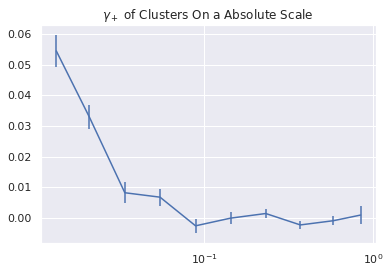

Aggregated xi:
[-26.5966 -33.4594 -12.8171 -17.0423  11.0185   0.9544 -13.8548  30.4433
  10.967   -2.    ]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -2108.1464  -3941.1041  -5317.4897  -7374.2539 -10056.2144 -13016.6267
 -14774.8968 -12776.5726  -6030.8981   -382.1859]
------------------------------------------------------------------------------
Aggregated npairs:
[  488.  1019.  1571.  2539.  4156.  6702. 10108. 12904. 11169.  2290.]
------------------------------------------------------------------------------
Mean xi:
[-0.0545 -0.0328 -0.0082 -0.0067  0.0027  0.0001 -0.0014  0.0024  0.001
 -0.0009]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.32   -3.8676 -3.3848 -2.9044 -2.4197 -1.9422 -1.4617 -0.9901 -0.54
 -0.1669]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

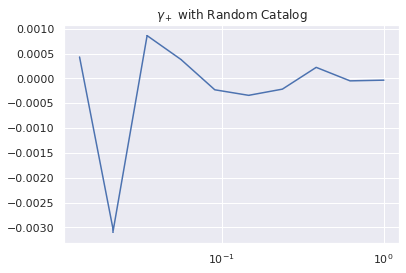

[ 4.3030e-04 -3.0562e-03  8.6036e-04  3.8116e-04 -2.2971e-04 -3.4155e-04
 -2.1683e-04  2.2134e-04 -5.0238e-05 -3.6069e-05]
[-6.8242e-06  4.8469e-05 -1.3645e-05 -6.0448e-06  3.6430e-06  5.4166e-06
  3.4386e-06 -3.5102e-06  7.9672e-07  5.7203e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

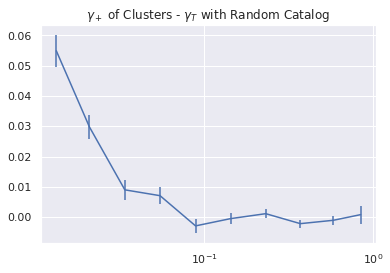

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

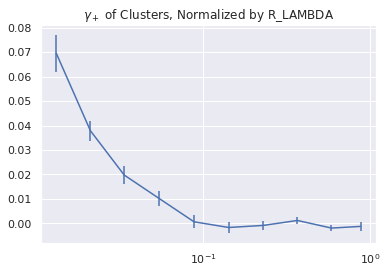

Aggregated xi:
[-17.9408 -29.4334 -24.4326 -20.7912  -2.0512   8.8366   6.7909 -14.1234
  25.7502   8.4243]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1116.9541  -2995.3209  -4193.8367  -5925.3062  -7705.4924 -10310.2629
 -12050.978  -11874.1708  -7194.7871   -911.7829]
------------------------------------------------------------------------------
Aggregated npairs:
[  258.   776.  1236.  2034.  3171.  5282.  8162. 11814. 13443.  6861.]
------------------------------------------------------------------------------
Mean xi:
[-0.0695 -0.0379 -0.0198 -0.0102 -0.0006  0.0017  0.0008 -0.0012  0.0019
  0.0012]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3293 -3.8599 -3.3931 -2.9131 -2.43   -1.952  -1.4765 -1.0051 -0.5352
 -0.1329]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)